# Courses recommendation system
# II. Build user-item preferences and content similarity structures

This is the second part of the Udacity Data Science Nanodegree capstone project, which consists in the creation of a course recommendation system.

Once the data is cleaned, the next step is to build structures that represent user preferences and similarities between courses. These structures are:

* A course content symilarity matrix to be able to measure the similarity between courses based on their description and title.
* A user-item matrix built from leads.
* A user-item matrix built from reviews.

This recommendation system is designed to work in a web application. Therefore, I think that converting these structures to a tabular format is a good idea so that data can be consulted quickly in a web environment.


## 1. Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from txtools.normalizer import TextNormalizer
from txtools.similarity import Similarity
from db_utils import connection

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Retrieve data

In this step I will retrieve the clean data from database.

Retrieve courses

In [2]:
courses_query = '''SELECT c.*, cat.name AS category_name FROM courses c 
                    JOIN categories cat ON c.category_id = cat.id'''

courses_df = pd.read_sql_query(courses_query, con=connection())

Retrieve leads

In [3]:
leads_query = 'SELECT * FROM clean_leads ORDER BY created_on DESC'

leads_df = pd.read_sql_query(leads_query, con=connection())

Retrieve reviews

In [4]:
reviews_query = 'SELECT * FROM clean_reviews ORDER BY created_on DESC'

reviews_df = pd.read_sql_query(reviews_query, con=connection())

## 3. Create a course content similarity matrix

I will create a similarity matrix for courses content. I will use the title and the description to compare the courses with each other. In the matrix, columns and rows indexes will be the course id and the intersection will be the similarity between them. The range of values will be between 0 and 1, where 0 means totally different and 1 means that the content is identical.

In [17]:
def create_similarity_matrix(df, sample_len=None):
    """ 
    Creates a course similarity matrix
    
    :param df DataFrame: courses dataframe. Must include title and description columns
    :param sample_len: Maximum number of courses used to create the matrix. If `None`, all courses in DataFrame
            will be used.
    :return np.ndarray: An m x m matrix representing the course similarities, where m is the number of courses.
        Example of a similarity matrix:
        
         [[0.99999994 0.         0.13075474 0.02665992]
          [0.         1.         0.00812627 0.00331377]
          [0.13075474 0.00812627 1.         0.0069054 ]
          [0.02665992 0.00331377 0.0069054  1.        ]]
          
        rows and columns represents a course, the elements in the matrix, represent the similarity between them.
    """
    if not sample_len:
        course_content = df['title'].str.cat(df['description'], sep='. ').values
    else:
        course_content = df['title'].str.cat(df['description'], sep='. ').head(sample_len).values
    
    model = Pipeline([
        ('norm', TextNormalizer()),
        ('sim', Similarity())
    ])
    
    return model.fit_transform(course_content)
    
    
def create_similarity_df(df, min_similarity=0.5, sample_len=None):
    """
    Creates a course similarity DataFrame from a similarity matrix
    
    :param df DataFrame: Courses dataframe. Must include title and description columns
    :param min_similarity float: Minimum similarity to be included in DataFrame
    :param sample_len int: Maximum number of courses that will be included in the matrix
    
    :return DataFrame: a dataframe with following columns:
        a_course str: course id
        another_course str: course id
        similarity float: similarity between courses
    """
    sim_list = []
    sim_matrix = create_similarity_matrix(df, sample_len=sample_len)
    
    for idx, similarities in enumerate(sim_matrix):
        a_course_id = df.iloc[idx]['id']
        
        for idx_sims, sim_score in enumerate(similarities):
            if idx == idx_sims:
                continue

            if sim_score < min_similarity:
                continue

            another_course_id = df.iloc[idx_sims]['id']

            sim_list.append({'a_course_id': a_course_id, 
                             'another_course_id': another_course_id, 
                             'similarity': sim_score})

    return pd.DataFrame(sim_list)

I will create a similarity matrix with a sample of 50 courses

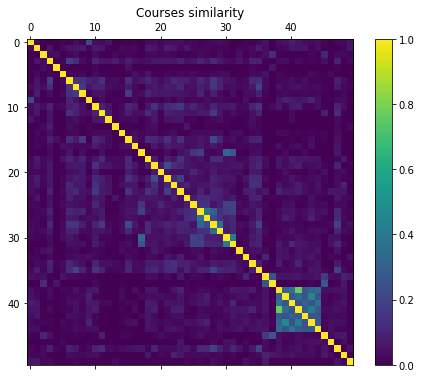

In [18]:
sims = create_similarity_matrix(courses_df, sample_len=50)

fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(sims, interpolation='nearest')
fig.colorbar(cax)
ax.set_title('Courses similarity')

plt.show();

The similarity dataframe will look like this:

In [19]:
sims_df_s50 = create_similarity_df(courses_df, sample_len=50)
sims_df_s50.head()

,a_course_id,another_course_id,similarity
0,170037187,170037258,0.772166
1,170037258,170037187,0.772166


### 3.1. Create courses content similarity DataFrame
And now, I will create the similarities dataframe with the entire courses dataframe. <span style="color:red">**This process took approximately 8 hours on a MacBook pro (2.3 GHz Intel Core i5, 16 GB RAM)**</span>

In [20]:
sims_df = create_similarity_df(courses_df)

In [27]:
sims_df.head()

,a_course_id,another_course_id,similarity
0,170565193,170566126,0.606849
1,170563091,170263714,0.724279
2,170563091,170203253,0.548920
3,170563091,170008122,0.644050
4,170563091,170563098,0.827058


In [28]:
sims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74110 entries, 0 to 74109
Data columns (total 3 columns):
a_course_id          74110 non-null int64
another_course_id    74110 non-null int64
similarity           74110 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.7 MB


### 3.2. Save courses similarities into the database

In [29]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `courses_similarities`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `courses_similarities` (
  `a_course_id` varchar(9) NOT NULL,
  `another_course_id` varchar(9) NOT NULL,
  `similarity` double NOT NULL,
  PRIMARY KEY (`a_course_id`, `another_course_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save course similarities to database
sims_df.to_sql('courses_similarities', con=conn, if_exists='append', index=False)

## 4. Create the user-item matrices

Now, I will create the user item matrices

In [5]:
def create_ratings_user_item_matrix(df=reviews_df):
    """Creates a ratings user-item matrix DataFrame reviews

    :return: A DataFrame representing the ratings user-item matrix
    """
    user_items = df[['user_id', 'course_id', 'rating']]

    return user_items.groupby(['user_id', 'course_id'])['rating'].max().unstack()

def create_leads_user_item_matrix(df=leads_df):
    """Creates a leads user-item matrix DataFrame reviews

    :return: A DataFrame representing the leads user-item matrix
    """
    user_items = df[['user_id', 'course_id']]

    user_item_matrix = user_items.groupby(['user_id', 'course_id'])['course_id'].max().unstack()
    user_item_matrix = user_item_matrix.where(user_item_matrix.isnull(), other=1)
    user_item_matrix = user_item_matrix.fillna(0)

    return user_item_matrix

In [9]:
ratings_user_item_matrix = create_ratings_user_item_matrix(reviews_df)
leads_user_item_matrix = create_leads_user_item_matrix(leads_df)

### 4.1. Save the matrices to csv files

In [10]:
leads_user_item_matrix.to_csv('../data/leads_matrix.csv')
ratings_user_item_matrix.to_csv('../data/ratings_matrix.csv')

### 4.2. Checking the files size

In [12]:
leads_file_stats = os.stat('../data/leads_matrix.csv')
ratings_file_stats = os.stat('../data/ratings_matrix.csv')

print('Leads matrix size is {:.2f} MB'.format(leads_file_stats.st_size / (1024 * 1024)))
print('Ratings matrix size is {:.2f} MB'.format(ratings_file_stats.st_size / (1024 * 1024)))

Leads matrix size is 516.91 MB
Ratings matrix size is 254.21 MB


The user-item matrices seems to be too heavy (about 500MB and 255MB) to be loaded  on every request of a web application or an API. To overcome this problem, I will create 'pre-baked' recommendation structures, that is, all recommendations for each user and course. The disadvantage of this strategy is that it will be necessary to execute the generation processes of these structures very frequently to keep the data updated.

## 5. Collaborative filtering

### 5.1. Course-based collaborative filtering
 
This type of recommendation uses the leads generated by users on courses. This will be useful for each course to have a section called "Users who requested information about this course were also interested in...". 

That section will be very helpful for new users without information request history.

In [15]:
def requested_courses(user_id):
    """Returns an array of courses ids to which the user has generated lead

    :param user_id: User id for which we want to find generated leads
    :return: An array of courses ids to which the user has generated lead
    """
    return leads_df[leads_df['user_id'] == user_id]['course_id'].values

def course_course_recommendations(course_id, user_item_matrix, max_recs=10):
    """Returns an array of recommended courses based on leads generated in one course

    :param course_id: Course id for which we want to make the recommendations
    :param user_item_matrix: Leads user-item matrix
    :param max_recs: Maximum number of recommendations
    :return numpy.array: Array of courses recommended based on generated leads in one course
    """
    users = np.array(user_item_matrix[user_item_matrix.loc[:, course_id] == 1].index)
    recs = np.array([])

    for user_id in users:
        user_courses = requested_courses(user_id)

        new_recs = user_courses[user_courses != course_id]
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > max_recs:
            break

    return recs[:max_recs]

#### 5.1.1. Create a course-course recommendation DataFrame
This DataFrame will have two columns: column `course` represents the courses that have generated a lead and column `recommended`, where we will have the courses in which the same user who generated a lead in the courses of column `course` also generated leads.

In [17]:
recommendations = []
for course in leads_user_item_matrix.columns:
    recs = course_course_recommendations(course, leads_user_item_matrix)
    for rec in recs:
        recommendations.append({'course': course, 'recommended': rec})

course_course_recs_df = pd.DataFrame(recommendations)

In [18]:
course_course_recs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29469 entries, 0 to 29468
Data columns (total 2 columns):
course         29469 non-null object
recommended    29469 non-null object
dtypes: object(2)
memory usage: 460.5+ KB


#### 5.1.2. Save recommendations to database

In [19]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `recommended_courses_by_leads`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `recommended_courses_by_leads` (
  `course` varchar(9) NOT NULL,
  `recommended` varchar(9) NOT NULL,
  PRIMARY KEY (`course`, `recommended`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save recommendations to database
course_course_recs_df.to_sql('recommended_courses_by_leads', con=conn, if_exists='append', index=False)

### 5.2. Neighborhood based collaborative filtering using leads data
#### 5.2.1. The matrix sparsity problem
If we want to recommend courses to a user based on leads generated by other users, the problem gets worse. We have a matrix with 26186 users and 10331 courses, so we have more than 270 million cells, most of which with zero value (only 37085 filled with non-zero values).

In [20]:
leads_user_item_matrix.shape

(26186, 10331)

In [21]:
leads_user_item_matrix.shape[0] * leads_user_item_matrix.shape[1]

270527566

In [22]:
# Count non-zero values
(leads_user_item_matrix != 0).sum().sum()

37085

This causes two problems:

As I said before, we would need around 500MB memory to store the matrix. The second problem is that we need to perform operations on this matrix and the execution time of these operations would be very long.

Since the bulk of the computation performed will involve adding or multiplying zero values together, we could perform the calculations only when there is a connection between the user and the course, that is when the cell value is 1.

The solution to representing and working with sparse matrices is to use an alternate data structure to represent the sparse data.

SciPy provides an [implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) for creating sparse matrix from multiple structures.

I will create a sparse matrix from the `leads_user_item_matrix`:

In [23]:
sp_user_item_matrix = csr_matrix(leads_user_item_matrix.values, dtype='int8')
sp_user_item_matrix

<26186x10331 sparse matrix of type '<class 'numpy.int8'>'
	with 37085 stored elements in Compressed Sparse Row format>

In [24]:
print(sp_user_item_matrix)

  (0, 6556)	1
  (0, 6864)	1
  (0, 8165)	1
  (0, 9224)	1
  (1, 5944)	1
  (2, 8081)	1
  (3, 10232)	1
  (4, 10059)	1
  (5, 8159)	1
  (6, 293)	1
  (7, 6887)	1
  (8, 8843)	1
  (9, 9486)	1
  (10, 9855)	1
  (11, 5926)	1
  (12, 10232)	1
  (13, 10041)	1
  (14, 9094)	1
  (15, 4456)	1
  (16, 10041)	1
  (17, 10244)	1
  (18, 9181)	1
  (19, 1708)	1
  (19, 3784)	1
  (19, 3793)	1
  :	:
  (26163, 9055)	1
  (26164, 6535)	1
  (26165, 2569)	1
  (26166, 3669)	1
  (26167, 9058)	1
  (26168, 6090)	1
  (26169, 91)	1
  (26170, 9181)	1
  (26171, 3068)	1
  (26172, 10283)	1
  (26173, 7578)	1
  (26174, 10244)	1
  (26175, 10035)	1
  (26176, 1629)	1
  (26177, 2175)	1
  (26178, 1730)	1
  (26179, 9181)	1
  (26180, 3103)	1
  (26180, 9896)	1
  (26181, 7339)	1
  (26182, 9655)	1
  (26183, 6611)	1
  (26184, 10198)	1
  (26185, 365)	1
  (26185, 3825)	1


We see how the csr_matrix looks, the first element of tuple is the row index (users) and the second one is the column (courses) the value represents the relation between users and courses, in this case all values are 1.

The next step is to create a user-courses map, a dictionary whose keys are user ids and values ​​the matrix corresponding to that user.

In [25]:
user_leads_courses_map = {}
for i in range(0, sp_user_item_matrix.shape[0]):
    user_leads_courses_map[leads_user_item_matrix.index[i]] = sp_user_item_matrix[i]

In [26]:
with open('../data/user_courses_map.pickle', 'wb') as filename:
    pickle.dump(user_leads_courses_map, filename)


In [27]:
file = os.stat('../data/user_courses_map.pickle')

print('Leads matrix size is {:.2f} MB'.format(file.st_size / (1024 * 1024)))

Leads matrix size is 6.38 MB


6.38 MB vs. 516.91 MB, the improvement is amazing.

#### 5.2.2. Make recommendations

In [28]:
def find_similar_users(user_id, sparse_user_item_dict, min_similarity = 1):
    """ 
    Creates an array of similar users based on leads generated on the same courses
    
    :param user_id str: User id for which we want to find similar users
    :param user_item_matrix DataFrame: Leads user-item matrix
                          
    :return numpy.array: Array of similar users sorted by similarity
    """
    
    user_courses = np.array(sparse_user_item_dict[user_id].todense())[0]
    
    similarities = dict()
    
    for another_user_id, another_user_courses in sparse_user_item_dict.items():
        if user_id == another_user_id:
            continue
        
        similarity = np.dot(user_courses, np.array(another_user_courses.todense())[0])
        if similarity < min_similarity:
            continue        
                            
        similarities[another_user_id] = similarity
        

    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    
    return np.array([id for (id, similarity) in sorted_similarities])

def leads_based_recommendations_for_user(user_id, max_recs=10):
    """ 
    Returns an array of recommended courses for a user based on generated leads
    
    :param user_id str: User id for which we want to make the recommendations
    :param max_recs int: Maximum number of recommendations
                          
    :return numpy.array: Array of courses recommended based on generated leads
    """
    
    user_courses = requested_courses(user_id)
    similar_users = find_similar_users(user_id, user_leads_courses_map)

    recs = np.array([])

    for user in similar_users:
        neighbs_leads = requested_courses(user)

        new_recs = np.setdiff1d(neighbs_leads, user_courses, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > max_recs:
            break

    return recs[:max_recs]

def course_names(course_ids):
    return courses_df[courses_df['id'].isin(course_ids)]['title'].values

In [29]:
user_id = '1460318498c1f53bb880ce2e6d9ef64b'

print('User courses:')
print(course_names(requested_courses(user_id)))

print('\nRecommended courses:')
print(course_names(leads_based_recommendations_for_user(user_id)))

User courses:
['Adobe Photoshop, Illustrator and Graphic Design Bundle Course']

Recommended courses:
['Enterprise Transformation Maturity Canvas'
 'ACCA-Accountancy Traineeship Program' 'HNC Graphic Design'
 'Graphics Design and Desktop Publishing'
 'Quality Management Systems (QMS) - Lead Auditor'
 'Internal Audit - OHSAS 18001 Occupational Health & Safety'
 'Advanced Strategic Management'
 'Adobe Graphic Design & Web Design Online Training Bundle'
 'Professional Diploma in Graphic Design - CPD Certified'
 'Auditing and Internal Control Skills']


It seems that the recommender works fine, it makes sense that a user who has generated lead in an Adobe Photoshop course is recommended courses on graphic design and other Adobe products.

### 5.3. Neighborhood based collaborative filtering using ratings

#### 5.3.1. Make recommendations

In [71]:
def rated_courses(user_id):
    """Returns an array of course ids rated by a user
    
    :param user_id: User identifier
    :return: Array of courses rated by a user
    """
    return reviews_df[reviews_df['user_id'] == user_id]['course_id'].values

def courses_liked(user_id, min_rating=7):
    """Returns an array of courses rated by a user with a rating higher than `min_rating`
    
    :param user_id str: User id for which we want to find courses rated
                          
    :return array: Array of course ids rated by a user
    """
    return reviews_df[(reviews_df['user_id'] == user_id) & (reviews_df['rating'] >= min_rating)]['course_id'].values

In [72]:
def compute_euclidean_distance(a_user_id, another_user_id, ratings_user_item_matrix):
    """Computes the euclidean distance between users taking into account the rated courses
    
    :param a_user_id str: Id of a user
    :param another_user_id str: Id of another user
    :param user_item_matrix DataFrame: The reviews user-item matrix
    :return float: The eculidean distance between the users
    """
    a_user_courses = rated_courses(a_user_id)
    another_user_courses = rated_courses(another_user_id)
    
    similar_courses = np.intersect1d(a_user_courses,
                                     another_user_courses, 
                                     assume_unique=True)
    
    # there's no courses in common
    if len(similar_courses) == 0:
        return np.nan
    
    a_user_courses = ratings_user_item_matrix.loc[a_user_id].values
    another_user_courses = ratings_user_item_matrix.loc[another_user_id].values
    
    return np.linalg.norm(a_user_courses - another_user_courses)

def find_closest_neighbors(user_id, user_courses_map):
    users = user_courses_map.keys()
    distances = []
    
    for another_user_id in users:
        if user_id == another_user_id:
            continue
            
        try: 
            distance = compute_euclidean_distance(user_id,
                                                  another_user_id,
                                                  user_courses_map)
        except KeyError:
            continue

        if np.isnan(distance):
            continue

        distances.append((another_user_id, distance))
        
    return distances.sort(key=lambda x: x[1])


In [66]:
distances = []
max = 10
for user_id in ratings_user_item_matrix.index:
    for another_user_id in ratings_user_item_matrix.index:
        if user_id == another_user_id:
            continue
            
        try: 
            distance = compute_euclidean_distance(user_id,
                                                  another_user_id,
                                                  ratings_user_item_matrix)
        except KeyError:
            continue

        if np.isnan(distance):
            continue

        distances.append({'a_user_id': user_id, 'another_user_id': another_user_id, 'eucl_distance': distance})
    if len(distances) >= 10:
        break
        
eucl_distances_df = pd.DataFrame(distances)

KeyboardInterrupt: 

In [ ]:
eucl_distances_df.head()

In [45]:
def make_rating_recommendations(user_id, max_recs=10):
    """Returns an array of recommended courses for a user based on users ratings
    
    :param user_id str: User id for which we want to make the recommendations
    :param max_recs int: Maximum number of recommendations
    :return numpy.array: Array of courses recommended based on user ratings
    """
    recs = np.array([])
    
    user_rated_courses = rated_courses(user_id)
    closest_neighbors = find_closest_neighbors(user_id, user_rating_courses_map)
    
    if not closest_neighbors:
        return recs
    
    for neighbor, _ in closest_neighbors:
        neighbs_likes = courses_liked(neighbor)
        
        #Obtain recommendations for each neighbor
        new_recs = np.setdiff1d(neighbs_likes, user_rated_courses, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) > num_recs-1:
            break
            
    return recs
    

In [46]:
user_id = '000958fdaefe0dd06f5d7c4e4a5f28d1'
print(course_names(courses_liked(user_id)))
print(course_names(make_rating_recommendations(user_id)))

['BSc (Hons) Environmental Management and Ecology']
[]


In [70]:
ratings_user_item_matrix.loc['000958fdaefe0dd06f5d7c4e4a5f28d1'].values

array([nan, nan, nan, ..., nan, nan, nan])